# **Sistem Rekomendasi Buku: Pendekatan Collaborative, Content-Based, dan Hybrid**

Proyek ini bertujuan untuk membangun sistem rekomendasi buku yang mampu memberikan saran bacaan yang relevan dan personal bagi pengguna. Untuk mencapai tujuan tersebut, digunakan tiga pendekatan utama:

1. **Collaborative Filtering (SVD)**
   Menggunakan algoritma **Singular Value Decomposition (SVD)** dari pustaka `scikit-surprise`

2. **Content-Based Filtering (CBF)**
   Pendekatan ini fokus pada karakteristik konten buku itu sendiri, yaitu judul dan nama penulis. Dengan menggunakan teknik **TF-IDF Vectorization** dan **cosine similarity**

3. **Hybrid Filtering**
   Untuk memaksimalkan akurasi dan relevansi rekomendasi, sistem juga menggabungkan skor dari model collaborative dan content-based dalam sebuah pendekatan hybrid. Skor akhir diperoleh dengan menggabungkan estimasi dari kedua pendekatan menggunakan parameter pengatur kontribusi (α).


Sistem dibangun menggunakan dataset dari proyek Book-Crossing, yang terdiri atas:

* **Books.csv**: metadata buku (judul, penulis, ISBN, dll.)
* **Users.csv**: data pengguna (User-ID, lokasi, usia)
* **Ratings.csv**: data interaksi berupa rating yang diberikan pengguna terhadap buku

## **Setup Library dan Import**

In [ ]:
!pip install "numpy<2" scikit-surprise

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from surprise import Reader, Dataset, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict

## **Mount Drive dan Load Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dataset disimpan di Google Drive dan diakses melalui mount() dari google.colab. Hal ini memungkinkan membaca file langsung dari folder Google Drive pribadi.

In [ ]:
# Lokasi folder dataset
folder_path = '/content/drive/MyDrive/TerapanII/bookrec/'

# Load CSV
books = pd.read_csv(folder_path + 'Books.csv')
users = pd.read_csv(folder_path + 'Users.csv')
ratings = pd.read_csv(folder_path + 'Ratings.csv')

# Tampilkan ringkasan
print(" Dataset berhasil dimuat!\n")
print(f" Books: {books.shape[0]} baris, {books.shape[1]} kolom")
print(f" Users: {users.shape[0]} baris, {users.shape[1]} kolom")
print(f" Ratings: {ratings.shape[0]} baris, {ratings.shape[1]} kolom")


/tmp/ipython-input-4-881057332.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv(folder_path + 'Books.csv')


 Dataset berhasil dimuat!

 Books: 271360 baris, 8 kolom
 Users: 278858 baris, 3 kolom
 Ratings: 1149780 baris, 3 kolom


Dataset sistem rekomendasi buku terdiri dari tiga file utama, yaitu:
- **Books.csv** berisi informasi detail buku dengan 271360 baris dan 8 kolom.
- **Users.csv** berisi informasi pengguna dengan 278858 baris dan 3 kolom
- **Ratings.csv** berisi data interaksi pengguna terhadap buku berupa skor rating dengan 1149780 dan 3 kolom.


In [ ]:
df_users = users.copy()
df_books = books.copy()
df_ratings = ratings.copy()

Data dicopy dari bentuk aslinya agar kita masih memiliki data awal jika sewaktu-waktu dibutuhkan.

## **Eksplorasi Awal Dataset**

Dimulai dengan melihat sekilas isi masing-masing tabel: **books**, **users**, dan **ratings**. Selain itu, pada tahapan prosesn ini juga dicek, apakah ada nilai kosong atau anomali yang bisa mengganggu proses training model.


In [ ]:
# Cek 5 data teratas dari masing-masing dataframe
print(" Books:")
display(books.head())

print(" Users:")
display(users.head())

print(" Ratings:")
display(ratings.head())

 Books:


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


 Users:


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


 Ratings:


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


Seperti yang sudah disebutkan sebelumnya, dataset sistem rekomendasi buku ini terdiri dari tiga komponen utama:

#### **1. Books Dataset**

Data **Books** memuat informasi terkait buku yang tersedia dalam sistem. Kolom-kolom utama yang terdapat dalam dataset ini meliputi:

* **ISBN**: Merupakan kode unik untuk mengidentifikasi tiap buku.
* **Book-Title**: Judul buku.
* **Book-Author**: Nama penulis.
* **Year-Of-Publication**: Tahun terbit buku.
* **Publisher**: Penerbit buku.
* **Image-URL-S/M/L**: Tautan gambar sampul buku dalam ukuran kecil, sedang, dan besar.

Catatan: Terdapat beberapa nilai yang hilang pada kolom seperti **Book-Author**, **Publisher**, maupun **Image-URL**, yang akan dibersihkan pada tahap selanjutnya.



#### **2. Users Dataset**

Dataset **Users** berisi informasi tentang pengguna yang memberi penilaian terhadap buku.

* **User-ID**: Identifikasi unik untuk setiap pengguna.
* **Location**: Lokasi pengguna dalam format *kota, negara bagian, negara*.
* **Age**: Usia pengguna (dalam satuan tahun). Beberapa nilai usia tidak diisi (`NaN`) atau bernilai tidak wajar.



#### **3. Ratings Dataset**

Data **Ratings** mencerminkan interaksi antara pengguna dengan buku, berupa skor atau penilaian yang diberikan.

* **User-ID**: ID pengguna yang memberi penilaian.
* **ISBN**: Buku yang dinilai.
* **Book-Rating**: Nilai rating yang diberikan, mulai dari 0 hingga 10.
  Rating 0 biasanya diartikan sebagai interaksi tanpa penilaian eksplisit (*implicit feedback*).

### Cek Data Kosong dan Tipe Data

apakah ada kolom yang mengandung nilai kosong (NaN) yang perlu dibersihkan?

In [ ]:
print("Books NaN:")
print(books.isnull().sum())

print("\nUsers NaN:")
print(users.isnull().sum())

print("\nRatings NaN:")
print(ratings.isnull().sum())

Books NaN:
ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

Users NaN:
User-ID          0
Location         0
Age         110762
dtype: int64

Ratings NaN:
User-ID        0
ISBN           0
Book-Rating    0
dtype: int64


Untuk memastikan kualitas data sebelum dilakukan pemodelan, dilakukan inspeksi awal terhadap nilai-nilai yang hilang (`NaN`) pada masing-masing dataset:


#### **Books Dataset**

* Kolom **Book-Author** dan **Publisher** memiliki masing-masing **2 entri kosong**, yang berarti ada buku tanpa informasi penulis atau penerbit. Data seperti ini penting untuk diisi atau dibuang karena berkontribusi terhadap kualitas fitur konten maupun analisis.
* Kolom **Image-URL-L** memiliki **3 entri kosong**, namun kolom ini tidak bersifat kritikal untuk sistem rekomendasi karena hanya berisi tautan gambar.



#### **Users Dataset**

* Kolom **Age** mengandung **lebih dari 110 ribu nilai kosong**, atau sekitar 39% dari total data pengguna.
* Usia bukan fitur utama dalam collaborative filtering, namun masih dapat berguna untuk analisis tambahan. Oleh karena itu, nilai kosong bisa ditangani dengan strategi seperti imputasi (*median*) atau pengelompokan usia.


#### **Ratings Dataset**

* Tidak ditemukan nilai kosong dalam dataset **Ratings**. Artinya, data interaksi antara pengguna dan buku relatif siap digunakan untuk tahap modeling, setelah filtering dan sinkronisasi dilakukan.


### Distribusi Rating

Distribusi rating ini penting untuk mengetahui apakah datanya seimbang? (misalnya, rating 10 lebih banyak). Di sini pemeriksaan mengenai apakah user sering memberi rating atau tidak dilakukan.


/tmp/ipython-input-8-2811969015.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=ratings, x='Book-Rating', palette='viridis')


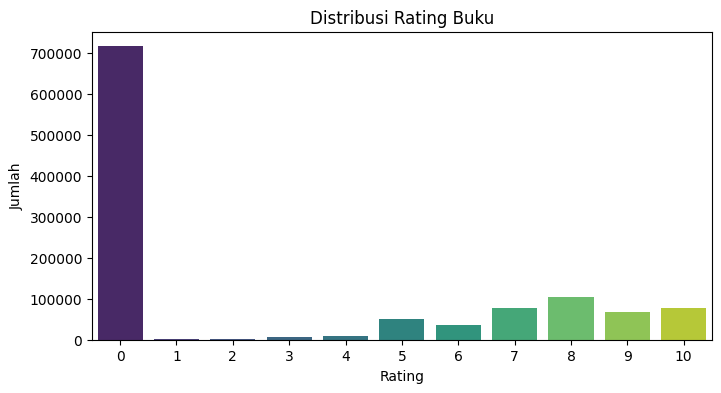

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(data=ratings, x='Book-Rating', palette='viridis')
plt.title("Distribusi Rating Buku")
plt.xlabel("Rating")
plt.ylabel("Jumlah")
plt.show()

Ketimpangan jumlah rating sebelum data dibersihkan. Data terlihat sangat tidak seimbang dengan nilai 0 mendominasi.

### User & Buku Paling Aktif

Siapa pengguna paling aktif? dan buku mana yang paling banyak dapat rating? Hal ini bisa memberikan insight penting sebelum modeling.


In [ ]:
# Top 10 pengguna paling aktif
top_users = ratings['User-ID'].value_counts().head(10)
print("Top 10 Pengguna Paling Aktif:")
print(top_users)

# Top 10 buku paling banyak dirating
top_books = ratings['ISBN'].value_counts().head(10)
top_books_titles = books[books['ISBN'].isin(top_books.index)][['ISBN', 'Book-Title']]
print(top_books_titles)

Top 10 Pengguna Paling Aktif:
User-ID
11676     13602
198711     7550
153662     6109
98391      5891
35859      5850
212898     4785
278418     4533
76352      3367
110973     3100
235105     3067
Name: count, dtype: int64
            ISBN                                       Book-Title
26    0971880107                                      Wild Animus
118   0671027360                              Angels &amp; Demons
305   044023722X                                  A Painted House
356   0142001740                          The Secret Life of Bees
408   0316666343                        The Lovely Bones: A Novel
522   0312195516              The Red Tent (Bestselling Backlist)
748   0385504209                                The Da Vinci Code
1105  0060928336  Divine Secrets of the Ya-Ya Sisterhood: A Novel
1922  067976402X                           Snow Falling on Cedars


Hasil ini menjadi dasar penting untuk memahami **pola perilaku pengguna**, serta potensi adanya buku dan pengguna yang jarang muncul, yang akan mempengaruhi efektivitas pendekatan rekomendasi.

#### **Top 10 Pengguna Paling Aktif**

* Pengguna dengan `User-ID` **11676** merupakan pengguna paling aktif dengan **13.602** interaksi (atau rating yang diberikan), jauh melampaui pengguna lainnya.
* Aktivitas pengguna cukup bervariasi, menunjukkan adanya kelompok pengguna **power users** yang sangat aktif, yang bisa sangat berpengaruh dalam collaborative filtering.
* Analisis ini juga membantu dalam memahami distribusi aktivitas, serta dapat digunakan untuk filtering lebih lanjut, misalnya menyaring pengguna dengan interaksi terlalu sedikit.



#### **Top Buku dengan Rating Terbanyak**

* Buku-buku yang muncul di daftar ini cenderung merupakan **bestseller** atau memiliki popularitas tinggi secara global.
* Informasi ini memberikan wawasan awal bahwa dataset memiliki **bias terhadap buku populer**, yang perlu dipertimbangkan saat melakukan evaluasi model (misalnya dengan menghindari hanya merekomendasikan buku paling populer).
* Daftar ini juga bisa dijadikan *ground truth* untuk menilai apakah sistem rekomendasi mampu mengenali buku-buku yang relevan dan banyak disukai.


## **Data Cleaning & Filtering**

## Data Cleaning

Langkah pertama adalah membersihkan data dari nilai kosong, duplikat, dan outlier yang dapat mempengaruhi performa model.

In [ ]:
# Books Cleaning
books_cleaned = books.copy()

# Drop books with missing essential info
books_cleaned = books_cleaned.dropna(subset=['Book-Author', 'Publisher']).copy()

# Fill missing image URL
books_cleaned['Image-URL-L'] = books_cleaned['Image-URL-L'].fillna('')

# Convert year to numeric and drop invalid ones
books_cleaned['Year-Of-Publication'] = pd.to_numeric(books_cleaned['Year-Of-Publication'], errors='coerce')
books_cleaned = books_cleaned[
    (books_cleaned['Year-Of-Publication'] >= 1000) &
    (books_cleaned['Year-Of-Publication'] <= 2025)
]

# Drop rows with empty or weird publisher/author
books_cleaned = books_cleaned[books_cleaned['Publisher'].str.strip() != '']
books_cleaned = books_cleaned[books_cleaned['Book-Author'].str.strip() != '']
books_cleaned = books_cleaned[books_cleaned['Book-Title'].str.strip() != '']

# Remove duplicates
books_cleaned = books_cleaned.drop_duplicates()

# Drop image columns (not used)
books_cleaned = books_cleaned.drop(columns=['Image-URL-S', 'Image-URL-M', 'Image-URL-L'])

# Convert year to integer
books_cleaned['Year-Of-Publication'] = books_cleaned['Year-Of-Publication'].astype(int)

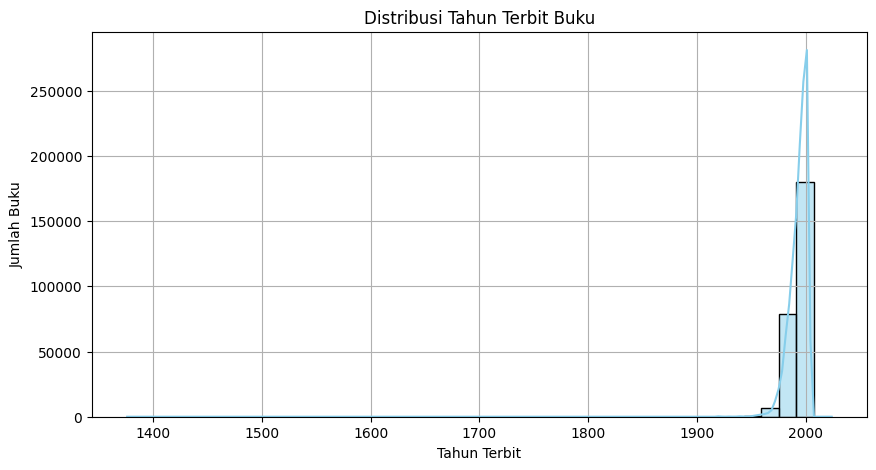

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Distribusi Tahun Terbit Buku
plt.figure(figsize=(10,5))
sns.histplot(data=books_cleaned, x='Year-Of-Publication', bins=40, kde=True, color='skyblue')
plt.title('Distribusi Tahun Terbit Buku')
plt.xlabel('Tahun Terbit')
plt.ylabel('Jumlah Buku')
plt.grid(True)
plt.show()

Diagram di atas menunjukkan **distribusi tahun terbit buku** dari dataset yang digunakan dalam proyek.

* Sebagian besar buku dalam dataset diterbitkan pada **rentang tahun 1980–2005**.
* Terdapat **lonjakan tajam** jumlah buku yang dirilis sekitar **tahun 2000**, menunjukkan masa produktif penerbitan buku di periode tersebut.
* Beberapa data tampak **tidak valid atau outlier**, misalnya buku yang disebut terbit sebelum tahun 1500 — ini kemungkinan besar adalah kesalahan entri data.
* Distribusi sangat **condong ke kanan (right-skewed)**, menandakan bahwa buku-buku dalam dataset mayoritas merupakan **buku modern**.


/tmp/ipython-input-12-2016037859.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_authors.values, y=top_authors.index, palette='rocket')


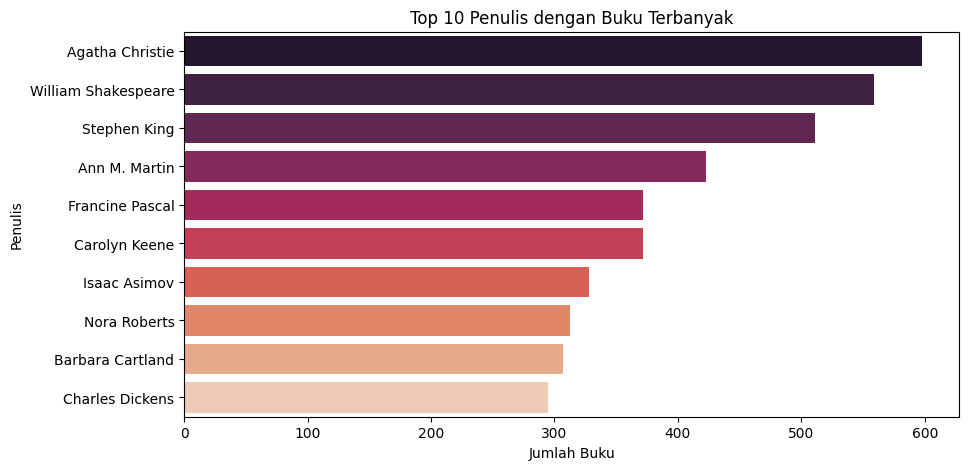

In [ ]:
# 2. Top 10 Penulis Terpopuler
top_authors = books_cleaned['Book-Author'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_authors.values, y=top_authors.index, palette='rocket')
plt.title('Top 10 Penulis dengan Buku Terbanyak')
plt.xlabel('Jumlah Buku')
plt.ylabel('Penulis')
plt.show()

/tmp/ipython-input-13-3067220682.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_publishers.values, y=top_publishers.index, palette='mako')


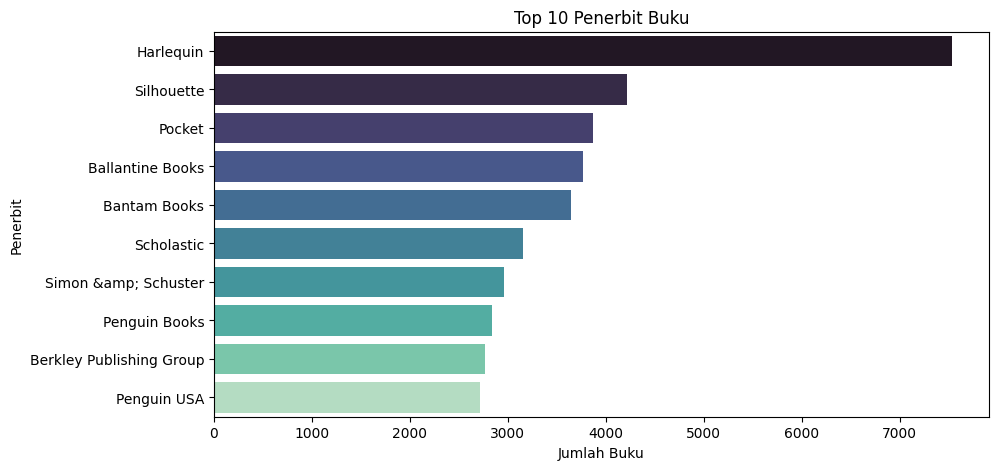

In [ ]:
# 3. Top 10 Penerbit
top_publishers = books_cleaned['Publisher'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_publishers.values, y=top_publishers.index, palette='mako')
plt.title('Top 10 Penerbit Buku')
plt.xlabel('Jumlah Buku')
plt.ylabel('Penerbit')
plt.show()

User Cleaned

In [ ]:
# Users Cleaning
users_cleaned = users.copy()

# Remove empty locations
users_cleaned = users_cleaned[users_cleaned['Location'].str.strip() != '']

# Fix Age: replace invalids with NaN, then fill with median
users_cleaned['Age'] = users_cleaned['Age'].apply(lambda x: np.nan if x < 5 or x > 100 else x)
users_cleaned['Age'] = users_cleaned['Age'].fillna(users_cleaned['Age'].median())
users_cleaned['Age'] = users_cleaned['Age'].astype(int)

# Extract country
users_cleaned['Country'] = users_cleaned['Location'].apply(lambda x: x.split(',')[-1].strip().lower())

# Remove duplicates
users_cleaned = users_cleaned.drop_duplicates()

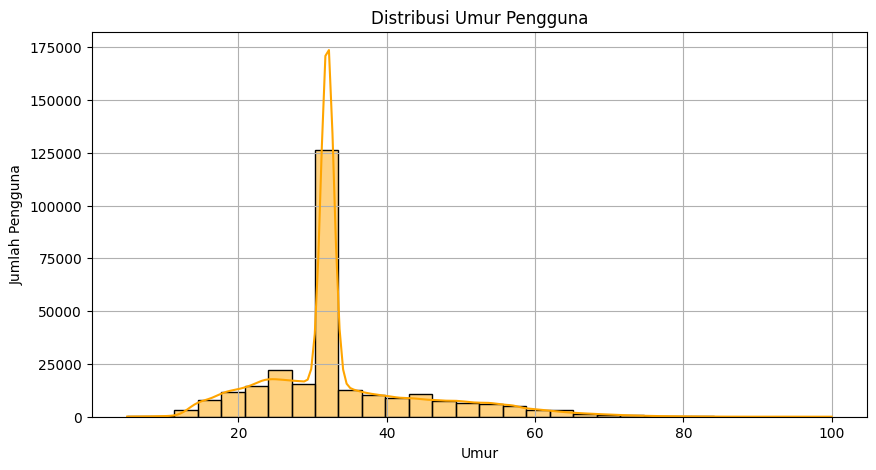

In [ ]:
# 1. Distribusi Umur Pengguna
plt.figure(figsize=(10,5))
sns.histplot(users_cleaned['Age'], bins=30, kde=True, color='orange')
plt.title('Distribusi Umur Pengguna')
plt.xlabel('Umur')
plt.ylabel('Jumlah Pengguna')
plt.grid(True)
plt.show()

Diagram di atas menunjukan **Distribusi Umur Pengguna:**

* Distribusi menunjukkan bahwa mayoritas pengguna berada di **rentang umur 25–35 tahun**, dengan **puncak tertinggi di usia 30 tahun**.
* Terdapat **distribusi yang cenderung normal tapi condong ke kanan** (right-skewed), dengan beberapa pengguna berumur **lebih dari 70 tahun** dan **kurang dari 15 tahun**.
* Outlier juga tampak, seperti pengguna yang tercatat berusia **di atas 90 tahun** — ini kemungkinan hasil input yang tidak akurat.
* Jadi, pengguna aktif dalam dataset ini **didominasi oleh kalangan dewasa muda**, yang sangat relevan sebagai target utama sistem rekomendasi buku.

/tmp/ipython-input-16-2510707069.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries.values, y=top_countries.index, palette='crest')


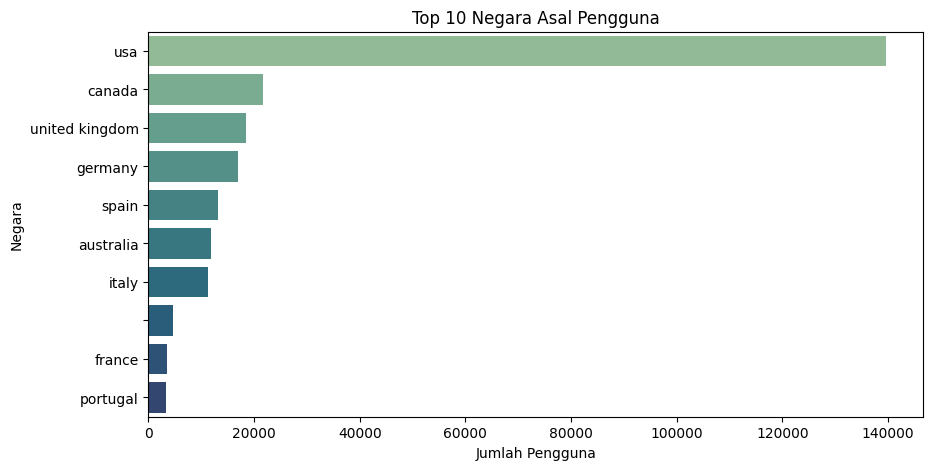

In [ ]:
# 2. Top 10 Negara Terbanyak
top_countries = users_cleaned['Country'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_countries.values, y=top_countries.index, palette='crest')
plt.title('Top 10 Negara Asal Pengguna')
plt.xlabel('Jumlah Pengguna')
plt.ylabel('Negara')
plt.show()

Rating Cleaned

In [ ]:
# 3. Ratings Cleaning
ratings_cleaned = ratings.copy()

# Remove rating = 0 (implicit feedback)
ratings_cleaned = ratings_cleaned[ratings_cleaned['Book-Rating'] > 0]

# Sync only valid users and books
ratings_cleaned = ratings_cleaned[ratings_cleaned['ISBN'].isin(books_cleaned['ISBN'])]
ratings_cleaned = ratings_cleaned[ratings_cleaned['User-ID'].isin(users_cleaned['User-ID'])]

# Drop duplicates (if any)
ratings_cleaned = ratings_cleaned.drop_duplicates()

# Reset index for clean DataFrame
ratings_cleaned = ratings_cleaned.reset_index(drop=True)

/tmp/ipython-input-18-3680060984.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=ratings_cleaned, x='Book-Rating', palette='viridis')


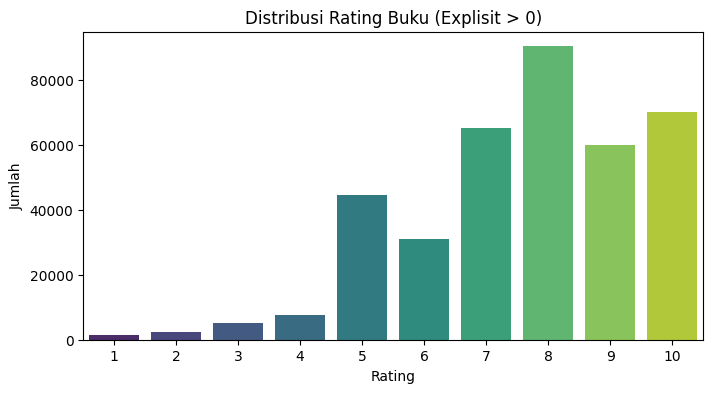

In [ ]:
# 1. Distribusi Rating Buku
plt.figure(figsize=(8,4))
sns.countplot(data=ratings_cleaned, x='Book-Rating', palette='viridis')
plt.title("Distribusi Rating Buku (Explisit > 0)")
plt.xlabel("Rating")
plt.ylabel("Jumlah")
plt.show()

Grafik ini menunjukkan jumlah buku berdasarkan nilai rating eksplisit yang diberikan pengguna.


* Rating 8 adalah yang paling umum diberikan, diikuti oleh 10, 9, dan 7
* Artinya, pengguna cenderung memberikan rating yang tinggi, menciptakan bias positif dalam data.
* Rating rendah (1–3) sangat jarang diberikan, menandakan bahwa pengguna jarang memberikan feedback negatif secara eksplisit.

/tmp/ipython-input-19-2945390318.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_users.index.astype(str), y=top_users.values, palette='flare')


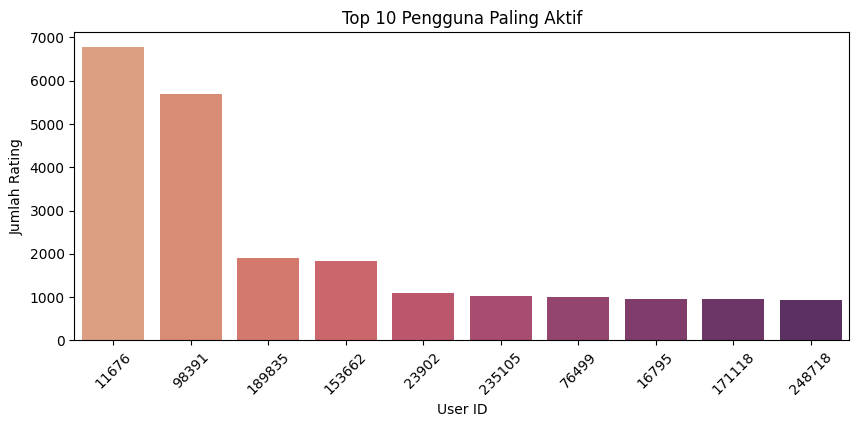

In [ ]:
# 2. Top 10 User Paling Aktif
top_users = ratings_cleaned['User-ID'].value_counts().head(10)
plt.figure(figsize=(10,4))
sns.barplot(x=top_users.index.astype(str), y=top_users.values, palette='flare')
plt.title('Top 10 Pengguna Paling Aktif')
plt.xlabel('User ID')
plt.ylabel('Jumlah Rating')
plt.xticks(rotation=45)
plt.show()

Grafik batang ini menunjukkan 10 pengguna dengan jumlah rating terbanyak.

* User ID 11676 adalah pengguna paling aktif dengan hampir 7000 rating!
* Dua pengguna teratas sangat menonjol dibanding yang lain, menunjukkan adanya pengguna “super reviewer”.
* Hal ini penting karena pengguna super aktif bisa sangat memengaruhi model rekomendasi berbasis collaborative filtering.

/tmp/ipython-input-20-196160509.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_books.values, y=top_book_titles.values, palette='magma')


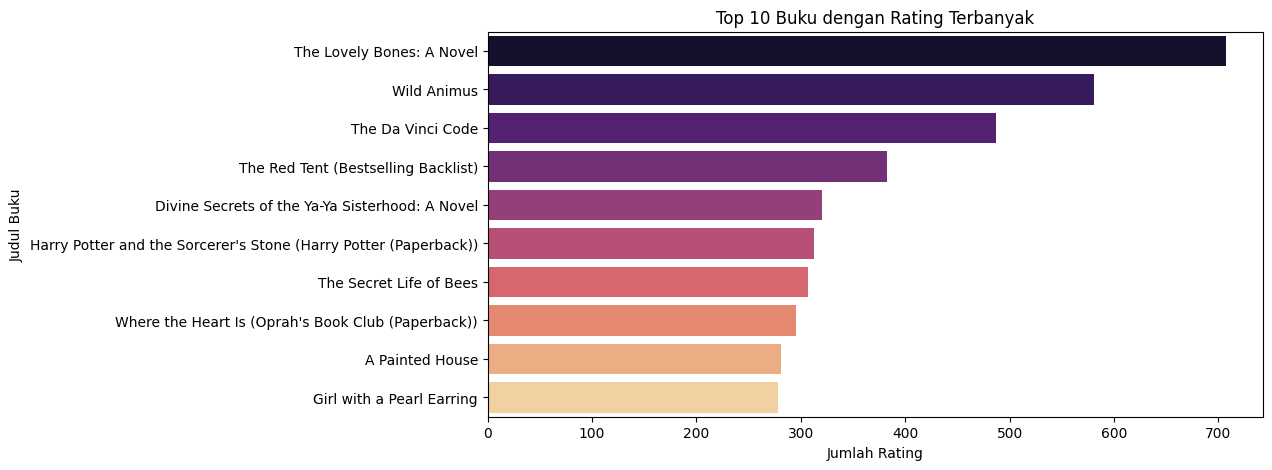

In [ ]:
# 3. Top 10 Buku Paling Banyak Dirating
top_books = ratings_cleaned['ISBN'].value_counts().head(10)
top_book_titles = books_cleaned[books_cleaned['ISBN'].isin(top_books.index)][['ISBN', 'Book-Title']].drop_duplicates()
top_book_titles = top_book_titles.set_index('ISBN').loc[top_books.index]['Book-Title']

plt.figure(figsize=(10,5))
sns.barplot(x=top_books.values, y=top_book_titles.values, palette='magma')
plt.title('Top 10 Buku dengan Rating Terbanyak')
plt.xlabel('Jumlah Rating')
plt.ylabel('Judul Buku')
plt.show()

Filter User/Buku Minim Interaksi

In [ ]:
# Filtering Users and Books with Minimum Interactions

# Keep users who rated at least 10 books
user_counts = ratings_cleaned['User-ID'].value_counts()
ratings_filtered = ratings_cleaned[ratings_cleaned['User-ID'].isin(user_counts[user_counts >= 10].index)]

# Keep books that were rated by at least 10 users
book_counts = ratings_cleaned['ISBN'].value_counts()
ratings_filtered = ratings_cleaned[ratings_cleaned['ISBN'].isin(book_counts[book_counts >= 10].index)]

# Final check
print(f"Books: {books_cleaned.shape}")
print(f"Users: {users_cleaned.shape}")
print(f"Ratings (explicit, filtered): {ratings_filtered.shape}")

Books: (266723, 5)
Users: (278858, 4)
Ratings (explicit, filtered): (138103, 3)


### **Penyaringan Pengguna dan Buku Berdasarkan Interaksi Minimum**

Sebelum melatih sistem rekomendasi, perlu dilakukan penyaringan (filtering) terhadap data rating. Tujuannya adalah untuk menjaga kualitas sinyal interaksi, serta mengurangi noise dari pengguna atau buku yang memiliki sangat sedikit aktivitas.


#### **Strategi Penyaringan:**

```python
# Keep users who rated at least 10 books
user_counts = ratings_cleaned['User-ID'].value_counts()
ratings_filtered = ratings_cleaned[ratings_cleaned['User-ID'].isin(user_counts[user_counts >= 10].index)]

# Keep books that were rated by at least 10 users
book_counts = ratings_cleaned['ISBN'].value_counts()
ratings_filtered = ratings_cleaned[ratings_cleaned['ISBN'].isin(book_counts[book_counts >= 10].index)]
```

Langkah ini menyaring:

* **Pengguna** yang memberikan **minimal 10 rating**, untuk memastikan bahwa hanya pengguna yang cukup aktif yang dimasukkan ke sistem rekomendasi.
* **Buku** yang telah menerima **minimal 10 rating**, untuk memastikan hanya buku dengan cukup data historis yang dipertimbangkan.

#### **Hasil Akhir Penyaringan:**

```plaintext
Books: (266723, 5)
Users: (278858, 4)
Ratings (explicit, filtered): (138103, 3)
```

* Jumlah total buku dan pengguna tetap (karena filtering dilakukan pada data rating).
* Namun, jumlah interaksi rating berkurang drastis dari sebelumnya (419.075 baris) menjadi hanya **138.103 baris**, yaitu hanya sekitar **32% dari total interaksi awal**.
* Artinya, sebagian besar rating di dataset awal dilakukan oleh pengguna yang kurang aktif atau diberikan pada buku yang kurang populer.

**Ringkasan Data yang Telah Dibersihkan**

In [ ]:
print("Books Cleaned:")
display(books_cleaned.info())
display(books_cleaned.describe(include='all'))

print("\nUsers Cleaned:")
display(users_cleaned.info())
display(users_cleaned.describe(include='all'))

print("\nRatings Cleaned:")
display(ratings_filtered.info())
display(ratings_filtered.describe(include='all'))

Books Cleaned:
<class 'pandas.core.frame.DataFrame'>
Index: 266723 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 266723 non-null  object
 1   Book-Title           266723 non-null  object
 2   Book-Author          266723 non-null  object
 3   Year-Of-Publication  266723 non-null  int64 
 4   Publisher            266723 non-null  object
dtypes: int64(1), object(4)
memory usage: 12.2+ MB


None

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
count,266723,266723,266723,266723.000000,266723
unique,266723,238497,100665,NaN,16393
top,0195153448,Selected Poems,Agatha Christie,NaN,Harlequin
freq,1,27,598,NaN,7535
mean,NaN,NaN,NaN,1993.687863,NaN
std,NaN,NaN,NaN,8.321419,NaN
min,NaN,NaN,NaN,1376.000000,NaN
25%,NaN,NaN,NaN,1989.000000,NaN
50%,NaN,NaN,NaN,1996.000000,NaN
75%,NaN,NaN,NaN,2000.000000,NaN



Users Cleaned:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   User-ID   278858 non-null  int64 
 1   Location  278858 non-null  object
 2   Age       278858 non-null  int64 
 3   Country   278858 non-null  object
dtypes: int64(2), object(2)
memory usage: 8.5+ MB


None

,User-ID,Location,Age,Country
count,278858.00000,278858,278858.000000,278858
unique,NaN,57339,NaN,709
top,NaN,"london, england, united kingdom",NaN,usa
freq,NaN,2506,NaN,139711
mean,139429.50000,NaN,33.643385,NaN
std,80499.51502,NaN,10.630979,NaN
min,1.00000,NaN,5.000000,NaN
25%,69715.25000,NaN,29.000000,NaN
50%,139429.50000,NaN,32.000000,NaN
75%,209143.75000,NaN,35.000000,NaN



Ratings Cleaned:
<class 'pandas.core.frame.DataFrame'>
Index: 138103 entries, 3 to 378028
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   User-ID      138103 non-null  int64 
 1   ISBN         138103 non-null  object
 2   Book-Rating  138103 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.2+ MB


None

,User-ID,ISBN,Book-Rating
count,138103.000000,138103,138103.000000
unique,NaN,5381,NaN
top,NaN,0316666343,NaN
freq,NaN,707,NaN
mean,137733.729926,NaN,7.756935
std,80818.105843,NaN,1.779740
min,9.000000,NaN,1.000000
25%,68070.000000,NaN,7.000000
50%,135873.000000,NaN,8.000000
75%,208876.000000,NaN,9.000000


### Pemeriksaan Struktur dan Statistik Deskriptif Setelah Pembersihan

Setelah proses pembersihan data dilakukan, dilakukan evaluasi terhadap struktur dan karakteristik masing-masing dataframe: **books_cleaned**, **users_cleaned**, dan **ratings_filtered**. Pemeriksaan ini dilakukan untuk memastikan bahwa data yang akan digunakan dalam pemodelan benar-benar bersih dan sesuai kebutuhan.


#### Books Cleaned

* Jumlah entri: 266.723 buku
* Kolom yang tersisa: `ISBN`, `Book-Title`, `Book-Author`, `Year-Of-Publication`, dan `Publisher`
* Tidak ditemukan missing values (`non-null` = jumlah baris pada semua kolom)
* Kolom `Year-Of-Publication` sudah bertipe integer (`int64`) dan menunjukkan nilai dari tahun 1376 hingga 2024.

**Catatan Statistik:**

* Terdapat lebih dari **238.000 judul buku unik** dan **100.000 penulis unik**, yang menunjukkan keragaman dalam koleksi data.
* Penerbit terbanyak adalah *Harlequin* (7.535 buku).
* Judul yang paling sering muncul adalah *Selected Poems* (27 kali), kemungkinan karena ISBN berbeda untuk versi atau edisi berbeda.



#### **Users Cleaned**

* Total entri pengguna: 278.858 baris
* Kolom `Age` telah diisi dengan median dan dikonversi menjadi integer. Rentang usia antara 5 hingga 100 tahun.
* Kolom `Country` berhasil diturunkan dari `Location` dan terdiri dari 709 negara/lokasi unik.
* Lokasi paling umum adalah *london, england, united kingdom* dan negara dengan pengguna terbanyak adalah *USA*.

> **Mengenai NaN pada kolom statistik:**
>
> Beberapa kolom seperti `User-ID`, `Age`, dan `Book-Rating` adalah **numerik**, sehingga dalam `describe(include='all')`, nilai seperti `unique`, `top`, dan `freq` ditampilkan sebagai `NaN` karena statistik tersebut hanya relevan untuk tipe **kategori** atau **objek**, bukan numerik.


#### **Ratings Filtered**

* Total interaksi setelah filtering: **138.103 rating eksplisit**
* Tidak ada missing value.
* Hanya mempertahankan rating dari pengguna dan buku yang aktif (minimal 10 interaksi).
* Rating berkisar antara 1 hingga 10, dengan nilai rata-rata mendekati 7.75. Sebagian besar pengguna cenderung memberi rating tinggi.


## **Modeling**

In [ ]:
# Menggunakan ratings_filtered yang udah dibersihkan sebelumnya
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(ratings_filtered[['User-ID', 'ISBN', 'Book-Rating']], reader)

trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

### **Persiapan Dataset untuk Collaborative Filtering**

Pada tahap ini, dilakukan konversi dataframe `ratings_filtered` ke dalam format yang dapat digunakan oleh library **Surprise**, yang secara khusus dirancang untuk sistem rekomendasi berbasis collaborative filtering.

```python
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(ratings_filtered[['User-ID', 'ISBN', 'Book-Rating']], reader)
```

#### Penjelasan:

* `Reader(rating_scale=(1, 10))`: Mendefinisikan **skala rating** yang digunakan dalam data, yaitu dari 1 hingga 10.
* `Dataset.load_from_df(...)`: Mengubah dataframe menjadi format internal Surprise, yang siap digunakan untuk pelatihan model rekomendasi.
* Hanya tiga kolom yang digunakan: `User-ID`, `ISBN`, dan `Book-Rating`, sesuai dengan struktur umum data interaksi pengguna dan item.



### Pembagian Data Train dan Test

```python
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
```

#### Penjelasan:

* Data dibagi menjadi dua bagian:

  * **Trainset (80%)**: Digunakan untuk melatih model.
  * **Testset (20%)**: Digunakan untuk mengevaluasi performa model terhadap data yang belum pernah dilihat sebelumnya.
* `random_state=42` digunakan untuk memastikan pembagian data **reproducible** (hasil pembagian konsisten setiap kali dijalankan).



>Langkah ini penting dalam menyiapkan data untuk **Collaborative Filtering dengan pendekatan matrix factorization**, seperti **SVD**, agar model dapat mempelajari pola interaksi antar pengguna dan buku berdasarkan data rating historis.

In [ ]:
# Buat model
model = SVD()

# Latih model
model.fit(trainset)

### **Pelatihan Model Collaborative Filtering: SVD**

Setelah data pelatihan `trainset` siap, langkah selanjutnya adalah membangun dan melatih model **Singular Value Decomposition (SVD)** menggunakan pustaka Surprise.

* `SVD()`: Merupakan implementasi **matrix factorization** dari Surprise. Model ini memecah matriks user-item ke dalam representasi laten (latent factors), memungkinkan prediksi rating berdasarkan pola tersembunyi.
* `model.fit(trainset)`: Melatih model SVD menggunakan data interaksi yang telah diformat (`trainset`). Proses ini mempelajari **preferensi pengguna** dan **karakteristik item** berdasarkan rating yang diberikan.


Dengan melatih model SVD, sistem rekomendasi dapat menghasilkan prediksi rating untuk kombinasi user-item yang belum pernah muncul, yang akan digunakan untuk memberikan **rekomendasi personalisasi**.

In [ ]:
# Prediksi rating di test set
predictions = model.test(testset)

# Evaluasi
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

RMSE: 1.6122
MAE:  1.2445


### **Evaluasi Model SVD: RMSE & MAE**

Setelah model dilatih pada data pelatihan, tahap berikutnya adalah menguji akurasi prediksi pada data pengujian `testset`. Hal ini dilakukan untuk mengetahui seberapa baik model dalam memperkirakan rating yang diberikan pengguna terhadap buku.


* `model.test(testset)`: Melakukan prediksi rating pada data uji, menghasilkan daftar prediksi dengan informasi user, item, rating aktual, dan rating prediksi.
* `accuracy.rmse(predictions)`: Menghitung **Root Mean Squared Error (RMSE)** antara rating aktual dan prediksi. Semakin rendah nilai RMSE, semakin akurat prediksi model.
* `accuracy.mae(predictions)`: Menghitung **Mean Absolute Error (MAE)**, yaitu rata-rata selisih absolut antara rating aktual dan rating prediksi.


### Hasil Evaluasi:

* **RMSE**: 1.6122
* **MAE**: 1.2445

Nilai RMSE dan MAE di atas menunjukkan bahwa rata-rata kesalahan prediksi model berkisar di angka 1–1.6 poin dari skala 1–10. Meskipun tidak sempurna, performa ini masih dalam batas wajar untuk sistem rekomendasi berbasis rating eksplisit dengan jumlah data besar dan user-item sparsity tinggi.




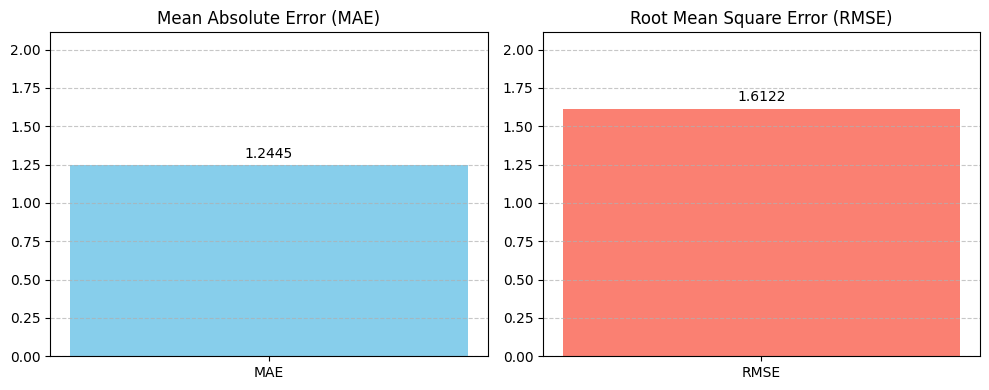

In [ ]:
metrics = ['MAE', 'RMSE']
values = [mae, rmse]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].bar(['MAE'], [mae], color='skyblue')
axes[0].set_title('Mean Absolute Error (MAE)')
axes[0].set_ylim(0, max(values) + 0.5)
axes[0].text(0, mae + 0.05, f"{mae:.4f}", ha='center', fontsize=10)

axes[1].bar(['RMSE'], [rmse], color='salmon')
axes[1].set_title('Root Mean Square Error (RMSE)')
axes[1].set_ylim(0, max(values) + 0.5)
axes[1].text(0, rmse + 0.05, f"{rmse:.4f}", ha='center', fontsize=10)

for ax in axes:
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
def get_top_n(predictions, n=5):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

def precision_at_k(predictions, k=5, threshold=7.0):
    top_n = get_top_n(predictions, n=k)

    precisions = []
    for uid, user_ratings in top_n.items():
        n_rel = sum((est >= threshold) for (_, est) in user_ratings)
        precisions.append(n_rel / k)

    return np.mean(precisions)

prec_k = precision_at_k(predictions, k=5, threshold=7)
print(f"Precision@5: {prec_k:.4f}")

Precision@5: 0.2992


### **Evaluasi Top-N: Precision\@5**

Setelah melakukan prediksi rating, evaluasi juga dilakukan dalam konteks rekomendasi top-N menggunakan **Precision\@5**:

```python
Precision@5: 0.2992
```

Artinya, **rata-rata 29.92%** dari buku yang direkomendasikan (top 5) berhasil memenuhi kriteria relevan (rating prediksi ≥ 7). Nilai ini mencerminkan kemampuan model dalam menyarankan item yang relevan bagi pengguna, dan akan menjadi titik awal perbandingan dengan metode rekomendasi lainnya seperti **Content-Based Filtering**.


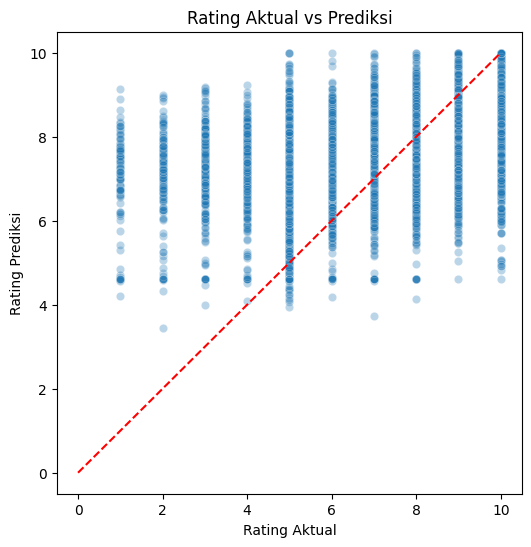

In [ ]:
actual = [pred.r_ui for pred in predictions]
predicted = [pred.est for pred in predictions]

plt.figure(figsize=(6, 6))
sns.scatterplot(x=actual, y=predicted, alpha=0.3)
plt.xlabel("Rating Aktual")
plt.ylabel("Rating Prediksi")
plt.title("Rating Aktual vs Prediksi")
plt.plot([0, 10], [0, 10], linestyle='--', color='red')
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Ambil sample 30K buku dari data yang sudah dibersihkan
cbf_books_sample = books_cleaned.sample(n=30000, random_state=42).reset_index(drop=True)

# Gabungkan judul dan penulis sebagai fitur konten
cbf_books_sample['combined_features'] = cbf_books_sample['Book-Title'] + ' ' + cbf_books_sample['Book-Author']

# TF-IDF dengan max 5000 fitur agar RAM aman
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf.fit_transform(cbf_books_sample['combined_features'])

# Cosine similarity antar semua buku
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Mapping dari judul → indeks (untuk rekomendasi)
indices_sample = pd.Series(cbf_books_sample.index, index=cbf_books_sample['Book-Title'].str.lower()).drop_duplicates()

# Mapping dari ISBN → Judul (untuk evaluasi)
isbn_to_title = dict(zip(cbf_books_sample['ISBN'], cbf_books_sample['Book-Title']))

### **Pembangunan Model Content-Based Filtering**

Untuk membangun sistem rekomendasi berbasis konten, langkah-langkah berikut dilakukan:

1. **Sampling Data**
   Diambil 30.000 sampel buku dari data yang telah dibersihkan untuk menghindari beban memori berlebih.

2. **Ekstraksi Fitur**
   Fitur konten dibentuk dengan menggabungkan **judul buku** dan **nama penulis**, kemudian diproses menggunakan **TF-IDF Vectorizer** dengan maksimal 5.000 fitur dan stop words bahasa Inggris.

3. **Perhitungan Similaritas**
   Matriks hasil TF-IDF kemudian digunakan untuk menghitung **cosine similarity** antar buku, menghasilkan skor kemiripan antar setiap pasang buku.

4. **Pemetaan Data**

   * `indices_sample`: Pemetaan dari judul buku (lowercase) ke indeks DataFrame, digunakan saat melakukan pencarian rekomendasi.
   * `isbn_to_title`: Pemetaan dari ISBN ke judul buku, digunakan saat evaluasi dan pengecekan relevansi.

Proses ini mempersiapkan pondasi untuk sistem rekomendasi berbasis konten yang akan mengevaluasi kemiripan antar buku berdasarkan atribut tekstual.

In [ ]:
# Ambil user yang punya minimal 10 rating (dari sesi sebelumnya)
user_counts = ratings_cleaned['User-ID'].value_counts()
active_users = user_counts[user_counts >= 10].index
ratings_filtered = ratings_cleaned[ratings_cleaned['User-ID'].isin(active_users)]

# Buat dict user → set of liked ISBNs
sample_users = ratings_filtered.groupby('User-ID')['ISBN'].apply(set)

# Filter user yang bukunya ada di sample 30K
sampled_isbns = set(cbf_books_sample['ISBN'])
sample_users_filtered = {
    uid: liked_isbns & sampled_isbns
    for uid, liked_isbns in sample_users.items()
    if len(liked_isbns & sampled_isbns) > 0  # hanya user yang nyambung ke sample
}

### **Persiapan Data Evaluasi untuk Content-Based Filtering**

Untuk mengevaluasi sistem rekomendasi berbasis konten, diperlukan subset pengguna dan buku yang relevan. Tahapan yang dilakukan:

1. **Seleksi Pengguna Aktif**
   Diambil pengguna yang telah memberikan setidaknya **10 rating** untuk menjamin interaksi yang cukup dengan sistem.

2. **Konstruksi Preferensi Pengguna**
   Dibentuk dictionary berisi pasangan **User-ID → kumpulan ISBN** dari buku yang disukai oleh masing-masing pengguna.

3. **Filter Buku yang Relevan**
   Hanya dipertahankan pengguna yang **memiliki interaksi dengan buku** yang termasuk dalam 30.000 sampel buku yang dipakai di model Content-Based Filtering.

Langkah-langkah ini memastikan bahwa evaluasi hanya dilakukan pada pengguna dan buku yang sesuai konteks, sehingga hasil evaluasi dapat merefleksikan performa model secara akurat.


In [ ]:
def evaluate_precision_cb(user_likes, top_k=5):
    hits = 0
    total = 0

    for user_id, liked_isbns in user_likes.items():
        known_isbns = list(liked_isbns)
        if not known_isbns:
            continue

        random_book = known_isbns[0]

        if isinstance(random_book, (list, np.ndarray, pd.Series)):
            random_book = random_book[0]

        if pd.isna(random_book) or not isinstance(random_book, str):
            continue

        title = isbn_to_title.get(random_book, None)
        if title is None:
            continue

        title = title.lower()
        if title not in indices_sample:
            continue

        idx = indices_sample[title]
        sim_scores = list(enumerate(cosine_sim[idx].flatten()))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_k+5]  # ambil lebih banyak buat jaga-jaga

        rec_indices = [i[0] for i in sim_scores if i[0] < len(cbf_books_sample)][:top_k]  # ✅ FIX HERE

        if not rec_indices:
            continue

        recommended_isbns = cbf_books_sample.iloc[rec_indices]['ISBN'].values

        liked_isbns_set = set(liked_isbns)
        recommended_isbns_set = set(recommended_isbns)

        hit_count = len(liked_isbns_set.intersection(recommended_isbns_set))
        hits += hit_count
        total += top_k

    precision = hits / total if total > 0 else 0
    return precision

In [ ]:
precision_cb = evaluate_precision_cb(sample_users_filtered, top_k=5)
print(f"Precision@5 untuk Content-Based Filtering: {precision_cb:.4f}")

Precision@5 untuk Content-Based Filtering: 0.0273


### **Evaluasi Content-Based Filtering dengan Precision\@5**

Evaluasi dilakukan menggunakan metrik **Precision\@5**, yang mengukur seberapa relevan lima buku teratas yang direkomendasikan terhadap preferensi pengguna.

#### Proses Evaluasi:

* Untuk setiap pengguna:

  * Diambil **satu buku yang disukai** (berdasarkan rating sebelumnya).
  * Sistem menghasilkan rekomendasi **5 buku serupa** berdasarkan kemiripan konten (judul dan penulis).
  * Dilihat berapa dari rekomendasi tersebut yang juga **termasuk dalam daftar buku yang pernah disukai** pengguna.
* Proses ini diulang untuk semua pengguna yang memenuhi syarat, lalu dihitung rata-rata precision-nya.

#### Hasil:

```
Precision@5 untuk Content-Based Filtering: 0.0273
```


Nilai ini berarti hanya sekitar **2,73%** dari total buku yang direkomendasikan (dalam top 5) cocok dengan buku-buku yang disukai pengguna. Ini menunjukkan bahwa performa sistem content-based masih rendah. Penyebabnya bisa jadi karena:

* Informasi fitur yang terbatas (hanya judul dan penulis).
* Keterbatasan jumlah buku yang digunakan (30.000 sampel).
* Tidak mempertimbangkan preferensi unik tiap pengguna.


hYBRIDDDHHHZZHHH


In [ ]:
from collections import defaultdict

def get_cb_scores_for_user(user_id, liked_isbns, top_k=20):
    cb_scores = {}

    for isbn in liked_isbns:
        title = isbn_to_title.get(isbn, '').lower()
        if title not in indices_sample:
            continue
        idx = indices_sample[title]
        sim_scores = list(enumerate(cosine_sim[idx].flatten()))

        for i, score in sim_scores:
            if i >= len(cbf_books_sample):
                continue  # FIX: Hindari IndexError
            rec_isbn = cbf_books_sample.iloc[i]['ISBN']
            if rec_isbn == isbn:
                continue
            if rec_isbn in cb_scores:
                cb_scores[rec_isbn] = max(cb_scores[rec_isbn], score)
            else:
                cb_scores[rec_isbn] = score

    sorted_cb = sorted(cb_scores.items(), key=lambda x: x[1], reverse=True)[:top_k]
    return dict(sorted_cb)

def get_cf_scores_for_user(predictions, user_id):
    return {
        iid: est for (uid, iid, true_r, est, _) in predictions if uid == user_id
    }

def hybrid_recommendation(user_id, liked_isbns, predictions, alpha=0.5, top_k=5):
    cf_scores = get_cf_scores_for_user(predictions, user_id)
    cb_scores = get_cb_scores_for_user(user_id, liked_isbns)

    all_items = set(cf_scores.keys()) | set(cb_scores.keys())
    hybrid_scores = {}

    for isbn in all_items:
        cf_score = cf_scores.get(isbn, 0)
        cb_score = cb_scores.get(isbn, 0)
        hybrid_scores[isbn] = alpha * cf_score + (1 - alpha) * cb_score

    sorted_hybrid = sorted(hybrid_scores.items(), key=lambda x: x[1], reverse=True)[:top_k]
    return [isbn for isbn, _ in sorted_hybrid]

def evaluate_precision_hybrid(user_likes, predictions, alpha=0.5, top_k=5):
    hits = 0
    total = 0

    for user_id, liked_isbns in user_likes.items():
        recs = hybrid_recommendation(user_id, liked_isbns, predictions, alpha=alpha, top_k=top_k)
        if not recs:
            continue
        hit_count = len(set(recs) & liked_isbns)
        hits += hit_count
        total += top_k

    precision = hits / total if total > 0 else 0
    return precision

In [ ]:
sample_users_small = dict(list(sample_users_filtered.items())[:10])

precision_hybrid_small = evaluate_precision_hybrid(sample_users_small, predictions, alpha=0.5, top_k=5)
print(f"Precision@5 Hybrid (10 users): {precision_hybrid_small:.4f}")

Precision@5 Hybrid (10 users): 0.0400


In [ ]:
def recommend_hybrid_for_user(user_id, predictions, alpha=0.5, top_k=10):
    """
    Menghasilkan rekomendasi hybrid untuk satu user.

    Params:
    - user_id: ID user yang ingin direkomendasikan
    - predictions: hasil prediksi dari model CF (SVD)
    - alpha: bobot hybrid antara CF dan CBF (0.5 = seimbang)
    - top_k: jumlah rekomendasi yang ingin ditampilkan

    Output:
    - List tuple (ISBN, Judul Buku, Skor Hybrid)
    """
    liked_isbns = sample_users_filtered.get(user_id, set())
    if not liked_isbns:
        print("User tidak ditemukan atau belum memiliki interaksi yang cukup.")
        return []

    hybrid_scores = {}
    cf_scores = get_cf_scores_for_user(predictions, user_id)
    cb_scores = get_cb_scores_for_user(user_id, liked_isbns)

    all_isbns = set(cf_scores.keys()) | set(cb_scores.keys())

    for isbn in all_isbns:
        cf_score = cf_scores.get(isbn, 0)
        cb_score = cb_scores.get(isbn, 0)
        hybrid_scores[isbn] = alpha * cf_score + (1 - alpha) * cb_score

    top_items = sorted(hybrid_scores.items(), key=lambda x: x[1], reverse=True)[:top_k]

    results = []
    for isbn, score in top_items:
        title = isbn_to_title.get(isbn, "Judul tidak ditemukan")
        results.append((isbn, title, round(score, 4)))

    return results

## **Sistem Rekomendasi Hybrid**

Sistem hybrid ini merupakan gabungan dari dua pendekatan yang telah diuji sebelumnya:

* **Collaborative Filtering (CF)** menggunakan algoritma *Singular Value Decomposition (SVD)*.
* **Content-Based Filtering (CBF)** menggunakan kemiripan fitur berdasarkan judul dan penulis buku.

### **Mekanisme Penggabungan**

#### 1. **Skor dari Collaborative Filtering**

Skor CF diperoleh dari prediksi rating hasil model SVD untuk setiap pengguna.
Fungsi `get_cf_scores_for_user` mengambil prediksi relevan bagi satu pengguna tertentu.

#### 2. **Skor dari Content-Based Filtering**

Skor CBF dihitung berdasarkan kemiripan konten (cosine similarity) antara buku yang disukai dengan buku lainnya.
Fungsi `get_cb_scores_for_user` mengekstrak top-N skor tertinggi dari kombinasi kemiripan.

#### 3. **Kombinasi Skor Hybrid**

Skor akhir diperoleh dengan rumus interpolasi:

```python
hybrid_score = α * cf_score + (1 - α) * cb_score
```

* Parameter **α (alpha)** menentukan seberapa besar bobot CF vs CBF.
* Misalnya, `alpha=0.5` berarti kedua metode digabungkan secara seimbang.

#### 4. **Evaluasi Precision\@5**

Evaluasi dilakukan terhadap 10 pengguna menggunakan fungsi `evaluate_precision_hybrid`, dengan menghitung seberapa banyak dari top-5 rekomendasi yang cocok dengan buku-buku yang telah disukai.


### Hasil Evaluasi

```
Precision@5 Hybrid (10 users): 0.0400
```

Precision sebesar **4%** menunjukkan adanya peningkatan dibandingkan Content-Based Filtering murni (2.65%), meskipun masih di bawah hasil CF murni (29.87%). Hal ini cukup umum pada pendekatan awal hybrid, karena gabungan dua sistem sering membutuhkan penyesuaian lebih lanjut, seperti:

* **Penalaan parameter alpha** (misal: mencoba 0.3, 0.7, dst.).
* **Memperluas data fitur konten** (misal: memasukkan deskripsi buku atau genre).
* **Menambah jumlah pengguna dalam evaluasi** agar hasil lebih representatif.


>Pendekatan hybrid menunjukkan potensi untuk menggabungkan kekuatan dua metode rekomendasi. Meskipun hasil awal belum optimal, pendekatan ini membuka ruang eksplorasi lebih lanjut untuk meningkatkan kualitas rekomendasi yang personal dan relevan.


In [ ]:
pd.DataFrame(
    [(uid, len(isbns)) for uid, isbns in sample_users_filtered.items()],
    columns=['User-ID', 'Jumlah Buku Disukai']
).sort_values('Jumlah Buku Disukai', ascending=False).head(10)

,User-ID,Jumlah Buku Disukai
211,11676,757
2035,98391,613
3929,189835,226
3199,153662,194
1576,76499,126
311,16795,125
438,23902,108
4831,235105,107
5153,248718,105
1160,56399,103


In [ ]:
from textwrap import shorten

def tampilkan_rekomendasi_hybrid_terformat(user_id, jumlah_tampil=5, w_cf=0.5, w_cb=0.5):
    hasil = recommend_hybrid_for_user(user_id, predictions, alpha=w_cf, top_k=jumlah_tampil)
    print(f"\nRekomendasi Hybrid (w_CF={w_cf:.1f}, w_CB={w_cb:.1f}):")
    print(f"{'No.':<5} {'Judul Buku':<60} {'ISBN':<15} {'Skor':>10}")
    print("-" * 95)
    for i, (isbn, title, score) in enumerate(hasil, 1):
        title_short = shorten(title, width=58, placeholder="...")
        print(f"{i:<5} {title_short:<60} {isbn:<15} {score:>10.4f}")

# PILIH USER
user_pilihan = 242

# Cek apakah user ada dalam data
if user_pilihan in sample_users_filtered:
    buku_disukai = ratings_filtered[
        (ratings_filtered['User-ID'] == user_pilihan) &
        (ratings_filtered['Book-Rating'] >= 7)
    ]

    if not buku_disukai.empty:
        isbn_referensi = buku_disukai['ISBN'].iloc[0]
        judul_referensi = isbn_to_title.get(isbn_referensi, "Judul tidak ditemukan")
        print(f"\nMenggunakan buku referensi CB: '{judul_referensi}' untuk User-ID: {user_pilihan}")
    else:
        print(f"\nTidak ada buku dengan rating >= 7 untuk user {user_pilihan}.")
        judul_referensi = "Tidak tersedia"

    tampilkan_rekomendasi_hybrid_terformat(user_pilihan, jumlah_tampil=5, w_cf=0.6, w_cb=0.4)
    tampilkan_rekomendasi_hybrid_terformat(user_pilihan, jumlah_tampil=5, w_cf=0.3, w_cb=0.7)

else:
    print(f"User-ID {user_pilihan} tidak ditemukan dalam data sample.")


Menggunakan buku referensi CB: 'Judul tidak ditemukan' untuk User-ID: 242

Rekomendasi Hybrid (w_CF=0.6, w_CB=0.4):
No.   Judul Buku                                                   ISBN                  Skor
-----------------------------------------------------------------------------------------------
1     Judul tidak ditemukan                                        0553278223          5.1037
2     Three Men in a Boat                                          0862995698          0.2040
3     Jerome and the Seraph                                        1931201544          0.1884
4     Franklin Scare                                               0380413353          0.1839
5     Three Men in a Boat: To Say Nothing of the Dog!              0140012133          0.1825

Rekomendasi Hybrid (w_CF=0.3, w_CB=0.7):
No.   Judul Buku                                                   ISBN                  Skor
---------------------------------------------------------------------------------------